
#  Diabetes Prediction — 02 Modeling

**Goal:** Train and evaluate baseline and tuned models for the Pima Indians Diabetes dataset.



In [1]:

# =================
# 0) Setup
# =================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional models
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

# Paths
DATA_PROCESSED_PATH = os.path.join('C:/Users/nazar/OneDrive/Documentos/machine learning/diabetes_processed.csv')

# If you saved elsewhere, override here:
# DATA_PROCESSED_PATH = r'C:/Users/nazar/OneDrive/Documentos/machine learning/diabetes_processed.csv'

assert os.path.exists(DATA_PROCESSED_PATH), f"Processed CSV not found at {DATA_PROCESSED_PATH}"


In [2]:

# =================
# 1) Load & split
# =================
df = pd.read_csv(DATA_PROCESSED_PATH)
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# numeric/ categorical split (dataset is numeric but keep generic)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocess: scale numeric features; passthrough categoricals (none expected here)
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', 'passthrough', cat_cols)  # keeps order; fine if empty
    ]
)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train size:', X_train.shape, ' Test size:', X_test.shape)


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Train size: (614, 8)  Test size: (154, 8)



## 2) Baseline models
We train a few standard models with default settings and report metrics.



=== Logistic Regression ===
Accuracy: 0.708  Precision: 0.600  Recall: 0.500  F1: 0.545  ROC-AUC: 0.813
Confusion matrix:
 [[82 18]
 [27 27]]


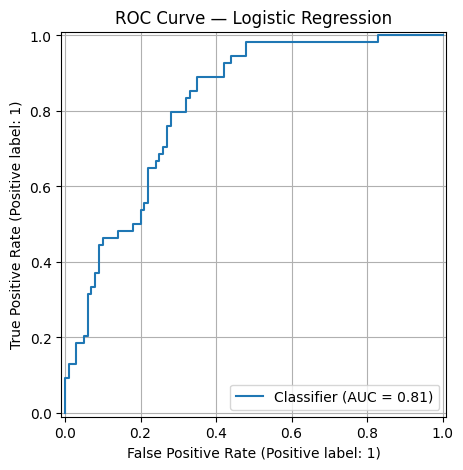


=== Random Forest ===
Accuracy: 0.779  Precision: 0.717  Recall: 0.611  F1: 0.660  ROC-AUC: 0.818
Confusion matrix:
 [[87 13]
 [21 33]]


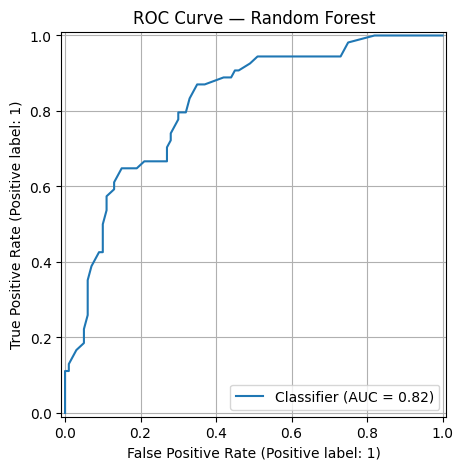

XGBoost not available — install with: pip install xgboost
LightGBM not available — install with: pip install lightgbm


In [3]:

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    # Some models may not implement predict_proba; handle gracefully
    try:
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    except Exception:
        # Fallback to decision_function if available
        try:
            scores = model.decision_function(X_te)
            from sklearn.preprocessing import MinMaxScaler
            y_proba = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()
            roc = roc_auc_score(y_te, y_proba)
        except Exception:
            y_proba = None
            roc = np.nan

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {roc:.3f}")
    print("Confusion matrix:\n", cm)

    if y_proba is not None:
        fig, ax = plt.subplots()
        RocCurveDisplay.from_predictions(y_te, y_proba, ax=ax)
        ax.set_title(f'ROC Curve — {name}')
        plt.show()

# Pipelines
logreg = Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000))])
rf = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(random_state=42))])

evaluate_model('Logistic Regression', logreg, X_train, X_test, y_train, y_test)
evaluate_model('Random Forest', rf, X_train, X_test, y_train, y_test)

if HAS_XGB:
    xgb = Pipeline([('prep', preprocess), ('clf', XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, colsample_bytree=0.8,
        random_state=42, eval_metric='logloss', n_jobs=-1
    ))])
    evaluate_model('XGBoost', xgb, X_train, X_test, y_train, y_test)
else:
    print("XGBoost not available — install with: pip install xgboost")


if HAS_LGBM:
    lgbm = Pipeline([('prep', preprocess), ('clf', LGBMClassifier(
        n_estimators=300, learning_rate=0.05, num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ))])
    evaluate_model('LightGBM', lgbm, X_train, X_test, y_train, y_test)
else:
    print("LightGBM not available — install with: pip install lightgbm")



## 3) Cross-validation (Logistic Regression example)


In [4]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logreg, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('LogReg ROC-AUC CV:', np.round(cv_scores, 3), '→ mean:', cv_scores.mean().round(3))


LogReg ROC-AUC CV: [0.825 0.867 0.852 0.829 0.81 ] → mean: 0.837



## 4) Hyperparameter tuning (RandomizedSearchCV on RandomForest)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best ROC-AUC CV: 0.84
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 3}

=== RandomForest (tuned) ===
Accuracy: 0.721  Precision: 0.641  Recall: 0.463  F1: 0.538  ROC-AUC: 0.801
Confusion matrix:
 [[86 14]
 [29 25]]


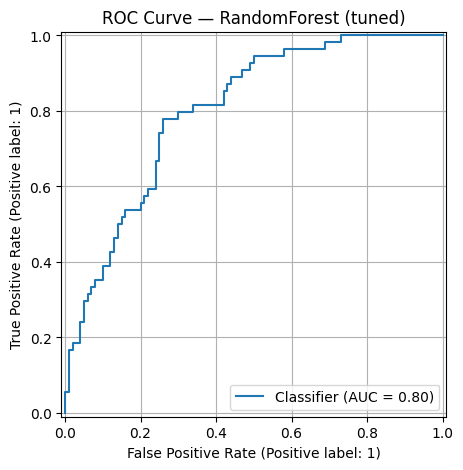

In [5]:

param_distributions = {
    'clf__n_estimators': [100, 200, 400, 600],
    'clf__max_depth': [None, 3, 5, 7, 10],
    'clf__min_samples_split': [2, 4, 6, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', None]
}

rf_pipe = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(random_state=42))])

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)

print('Best ROC-AUC CV:', search.best_score_.round(3))
print('Best params:', search.best_params_)

best_rf = search.best_estimator_
evaluate_model('RandomForest (tuned)', best_rf, X_train, X_test, y_train, y_test)



## 5) Save the best model (optional)


In [7]:

import joblib

best_model = best_rf  # or choose your favorite model above
out_dir = os.path.join('..', 'models')
os.makedirs(out_dir, exist_ok=True)
model_path = os.path.join(out_dir, 'C:/Users/nazar/OneDrive/Documentos/machine learning', 'diabetes_best_model.joblib')
joblib.dump(best_model, model_path)
print(f'Model saved to: {model_path}')


Model saved to: C:/Users/nazar/OneDrive/Documentos/machine learning\diabetes_best_model.joblib
